# Fast Compare and Design FeedForward Neural Network and Convolution Neural Network

- Note: Both use backprogation algorithm and gradient descent for optimization
- Also explains by visualize how CNN work 

## Set up and Load datasets MNIST

In [42]:
import torch 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [43]:
# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Select balanced 20% from label 0 and 20% from label 1
sample_frac = 0.2
torch.manual_seed(42)
idx0 = [i for i, (_, label) in enumerate(mnist_pytorch) if label == 0]
idx1 = [i for i, (_, label) in enumerate(mnist_pytorch) if label == 1]
n0 = max(1, int(len(idx0) * sample_frac))
n1 = max(1, int(len(idx1) * sample_frac))
gen = torch.Generator().manual_seed(42)
idx0_pick = torch.randperm(len(idx0), generator=gen)[:n0].tolist()
idx1_pick = torch.randperm(len(idx1), generator=gen)[:n1].tolist()
idx0_sample = [idx0[i] for i in idx0_pick]
idx1_sample = [idx1[i] for i in idx1_pick]
balanced_indices = idx0_sample + idx1_sample
perm = torch.randperm(len(balanced_indices), generator=gen).tolist()
balanced_indices = [balanced_indices[i] for i in perm]

# Create subset for labels 0 and 1 (balanced downsampled)
from torch.utils.data import Subset
mnist_subset = Subset(mnist_pytorch, balanced_indices)

# Create a DataLoader to load the subset in batches
train_loader_pytorch = torch.utils.data.DataLoader(mnist_subset, batch_size=1, shuffle=False)

In [44]:
# Check dataset info (balanced subset)
print(f"Total samples in balanced subset: {len(mnist_subset)}")
print(f"Samples per class target: label0 ~{int(len(idx0) * sample_frac)}, label1 ~{int(len(idx1) * sample_frac)}")

# Count labels in the subset
label_counts = {}
for _, label in mnist_subset:
    label_counts[label] = label_counts.get(label, 0) + 1
print(f"Label distribution in subset: {label_counts}")

Total samples in balanced subset: 2532
Samples per class target: label0 ~1184, label1 ~1348
Label distribution in subset: {0: 1184, 1: 1348}


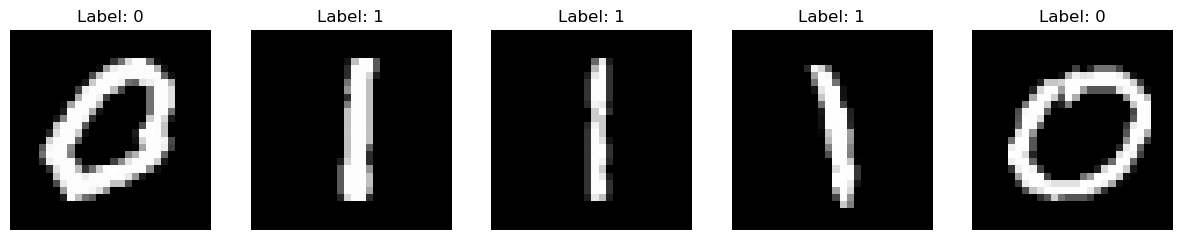

In [45]:
# Show first 5 samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (image, label) in enumerate(train_loader_pytorch):
    if i >= 5:
        break
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label.item()}')
    axes[i].axis('off')
plt.show()

## Implement Basic Architecture for both Neural Networks

In [46]:
from losses import CrossEntropyLoss
from layers import Dense, ReLU, Linear, Conv2D, Pool2D, Flatten
from models import Module

In [47]:
class FFNN(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Dense(28 * 28, 128, activation=ReLU())
        self.fc2 = Dense(128, 64, activation=ReLU())
        self.fc3 = Dense(64, 2, activation=Linear())  # Binary classification (labels 0/1)
        self.loss_fn = CrossEntropyLoss()
        
    def forward(self, X):
        out = self.fc1.forward(X)
        out = self.fc2.forward(out)
        out = self.fc3.forward(out)
        return out
    
    def backward(self, grad):
        grad = self.fc3.backward(grad)
        grad = self.fc2.backward(grad)
        grad = self.fc1.backward(grad)
        return grad
    
    def update(self, lr):
        self.fc1.update(lr)
        self.fc2.update(lr)
        self.fc3.update(lr)
        
    def predict(self, X):
        return self.forward(X)

In [48]:
class LeNet(Module):
    def __init__(self):
        super().__init__()
        # LeNet architecture (binary: labels 0 and 1)
        self.conv1 = Conv2D(in_channels=1, num_filters=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = Pool2D(pool_size=2, stride=2, type='max')  # Max pooling
        self.conv2 = Conv2D(in_channels=6, num_filters=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = Pool2D(pool_size=2, stride=2, type='max')  # Max pooling
        self.flatten = Flatten()
        # Input 28x28 -> conv1:24x24 -> pool1:12x12 -> conv2:8x8 -> pool2:4x4 -> 16*4*4=256
        self.fc1 = Dense(16 * 4 * 4, 120, activation=ReLU())
        self.fc2 = Dense(120, 84, activation=ReLU())
        self.fc3 = Dense(84, 2, activation=Linear())  # Binary classification (labels 0/1)
        self.loss_fn = CrossEntropyLoss()

    def forward(self, X):
        out = self.conv1.forward(X)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.pool2.forward(out)
        out = self.flatten.forward(out)
        out = self.fc1.forward(out)
        out = self.fc2.forward(out)
        out = self.fc3.forward(out)
        return out

    def backward(self, grad):
        grad = self.fc3.backward(grad)
        grad = self.fc2.backward(grad)
        grad = self.fc1.backward(grad)
        grad = self.flatten.backward(grad)
        grad = self.pool2.backward(grad)
        grad = self.conv2.backward(grad)
        grad = self.pool1.backward(grad)
        grad = self.conv1.backward(grad)
        return grad

    def update(self, lr):
        self.conv1.update(lr)
        self.conv2.update(lr)
        self.fc1.update(lr)
        self.fc2.update(lr)
        self.fc3.update(lr)

    def predict(self, X):
        return self.forward(X)

## Split data and Training

In [49]:
# Split subset into train/test loaders
import numpy as np
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(mnist_subset))
test_size = len(mnist_subset) - train_size
train_subset, test_subset = random_split(mnist_subset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")

Train samples: 2025, Test samples: 507


In [50]:
# Train LeNet (custom) and track metrics
model = LeNet()
lr = 0.03
epochs = 5
train_loss_hist, train_acc_hist, test_acc_hist = [], [], []

for epoch in range(1, epochs + 1):
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        X = images.permute(0, 2, 3, 1).numpy()  # to (batch, H, W, C)
        y = labels.numpy()  # shape (batch,)
        y_onehot = np.eye(2, dtype=np.float32)[y]  # one-hot for CE gradient
        logits = model.forward(X)
        loss, grad = model.loss_fn.loss_and_grad(logits, y_onehot)
        model.backward(grad)
        model.update(lr)
        running_loss += loss * y.shape[0]
        preds = np.argmax(logits, axis=1)
        correct += (preds == y).sum()
        total += y.shape[0]
    avg_loss = running_loss / total
    train_acc = correct / total if total > 0 else 0.0
    correct_test, total_test = 0, 0
    for images, labels in test_loader:
        X = images.permute(0, 2, 3, 1).numpy()
        y = labels.numpy()
        logits = model.predict(X)
        preds = np.argmax(logits, axis=1)
        correct_test += (preds == y).sum()
        total_test += y.shape[0]
    test_acc = correct_test / total_test if total_test > 0 else 0.0
    train_loss_hist.append(avg_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)
    print(f"Epoch {epoch}: train_loss={avg_loss:.4f} train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

Epoch 1: train_loss=0.7191 train_acc=0.5032 test_acc=0.5976
Epoch 2: train_loss=0.5909 train_acc=0.6899 test_acc=0.7988
Epoch 3: train_loss=0.4917 train_acc=0.8444 test_acc=0.8994
Epoch 4: train_loss=0.4134 train_acc=0.9244 test_acc=0.9527
Epoch 5: train_loss=0.3509 train_acc=0.9635 test_acc=0.9704


In [51]:
# Train FFNN (custom) and track metrics
model_ffnn = FFNN()
ffnn_lr = 0.03
ffnn_epochs = 5
ffnn_train_loss_hist, ffnn_train_acc_hist, ffnn_test_acc_hist = [], [], []

for epoch in range(1, ffnn_epochs + 1):
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        X = images.view(images.size(0), -1).numpy()  # flatten to (batch, 784)
        y = labels.numpy()
        y_onehot = np.eye(2, dtype=np.float32)[y]  # one-hot for CE gradient
        logits = model_ffnn.forward(X)
        loss, grad = model_ffnn.loss_fn.loss_and_grad(logits, y_onehot)
        model_ffnn.backward(grad)
        model_ffnn.update(ffnn_lr)
        running_loss += loss * y.shape[0]
        preds = np.argmax(logits, axis=1)
        correct += (preds == y).sum()
        total += y.shape[0]
    avg_loss = running_loss / total
    train_acc = correct / total if total > 0 else 0.0
    correct_test, total_test = 0, 0
    for images, labels in test_loader:
        X = images.view(images.size(0), -1).numpy()
        y = labels.numpy()
        logits = model_ffnn.predict(X)
        preds = np.argmax(logits, axis=1)
        correct_test += (preds == y).sum()
        total_test += y.shape[0]
    test_acc = correct_test / total_test if total_test > 0 else 0.0
    ffnn_train_loss_hist.append(avg_loss)
    ffnn_train_acc_hist.append(train_acc)
    ffnn_test_acc_hist.append(test_acc)
    print(f"FFNN Epoch {epoch}: train_loss={avg_loss:.4f} train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

FFNN Epoch 1: train_loss=0.8390 train_acc=0.5027 test_acc=0.5247
FFNN Epoch 2: train_loss=0.7198 train_acc=0.5635 test_acc=0.6292
FFNN Epoch 3: train_loss=0.6337 train_acc=0.6904 test_acc=0.7712
FFNN Epoch 4: train_loss=0.5682 train_acc=0.8202 test_acc=0.8639
FFNN Epoch 5: train_loss=0.5160 train_acc=0.9072 test_acc=0.9191


## Visualize each step and compare

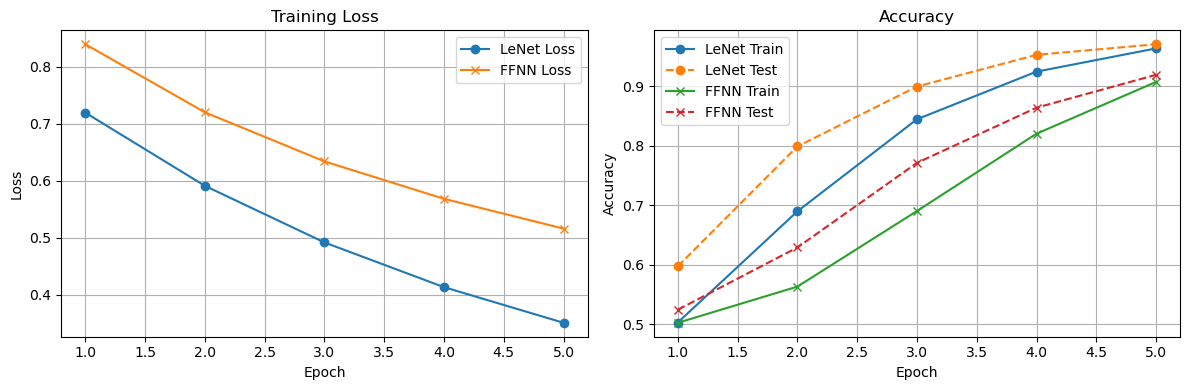

LeNet final test accuracy: 0.9704
FFNN final test accuracy: 0.9191


In [52]:
# Compare LeNet vs FFNN metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs_lenet = range(1, len(train_loss_hist) + 1)
epochs_ffnn = range(1, len(ffnn_train_loss_hist) + 1)

axes[0].plot(epochs_lenet, train_loss_hist, label='LeNet Loss', marker='o')
axes[0].plot(epochs_ffnn, ffnn_train_loss_hist, label='FFNN Loss', marker='x')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs_lenet, train_acc_hist, label='LeNet Train', marker='o')
axes[1].plot(epochs_lenet, test_acc_hist, label='LeNet Test', marker='o', linestyle='--')
axes[1].plot(epochs_ffnn, ffnn_train_acc_hist, label='FFNN Train', marker='x')
axes[1].plot(epochs_ffnn, ffnn_test_acc_hist, label='FFNN Test', marker='x', linestyle='--')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
print(f"LeNet final test accuracy: {test_acc_hist[-1]:.4f}")
print(f"FFNN final test accuracy: {ffnn_test_acc_hist[-1]:.4f}")

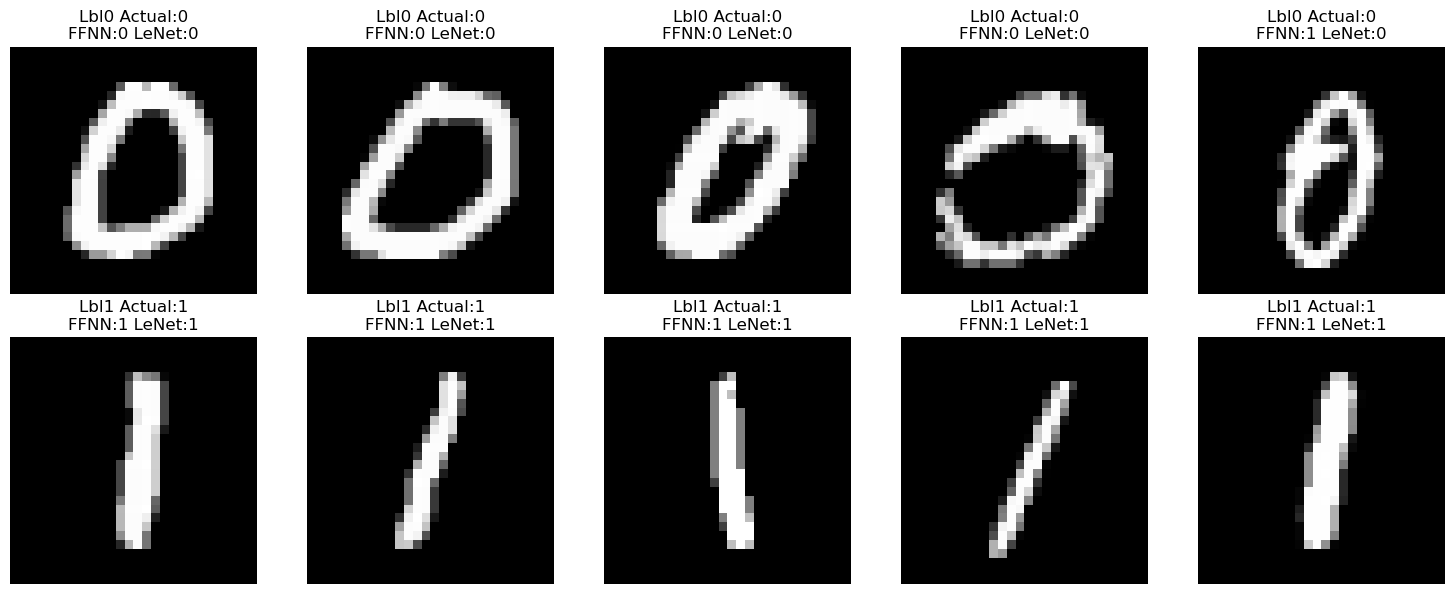

In [53]:
# Show 5 samples of label 0 and 5 samples of label 1 with predictions
target_per_class = 5
col = target_per_class
samples0, samples1 = [], []
for images_batch, labels_batch in test_loader:
    for img, lbl in zip(images_batch, labels_batch):
        if lbl.item() == 0 and len(samples0) < target_per_class:
            samples0.append((img, lbl))
        elif lbl.item() == 1 and len(samples1) < target_per_class:
            samples1.append((img, lbl))
    if len(samples0) >= target_per_class and len(samples1) >= target_per_class:
        break

# Stack and predict
def stack_and_predict(samples):
    imgs = torch.stack([p[0] for p in samples])
    lbls = torch.tensor([p[1] for p in samples])
    imgs_flat = imgs.view(imgs.size(0), -1).numpy()
    imgs_nhwc = imgs.permute(0, 2, 3, 1).numpy()
    ffnn_pred = np.argmax(model_ffnn.predict(imgs_flat), axis=1)
    lenet_pred = np.argmax(model.predict(imgs_nhwc), axis=1)
    return imgs, lbls.numpy(), ffnn_pred, lenet_pred

imgs0, lbls0, ffnn0, lenet0 = stack_and_predict(samples0)
imgs1, lbls1, ffnn1, lenet1 = stack_and_predict(samples1)

fig, axes = plt.subplots(2, col, figsize=(3 * col, 6))
for i in range(col):
    axes[0, i].imshow(imgs0[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Lbl0 Actual:{lbls0[i]}\nFFNN:{ffnn0[i]} LeNet:{lenet0[i]}")
    axes[0, i].axis('off')
    axes[1, i].imshow(imgs1[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Lbl1 Actual:{lbls1[i]}\nFFNN:{ffnn1[i]} LeNet:{lenet1[i]}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

## Deep Explain how CNNs work

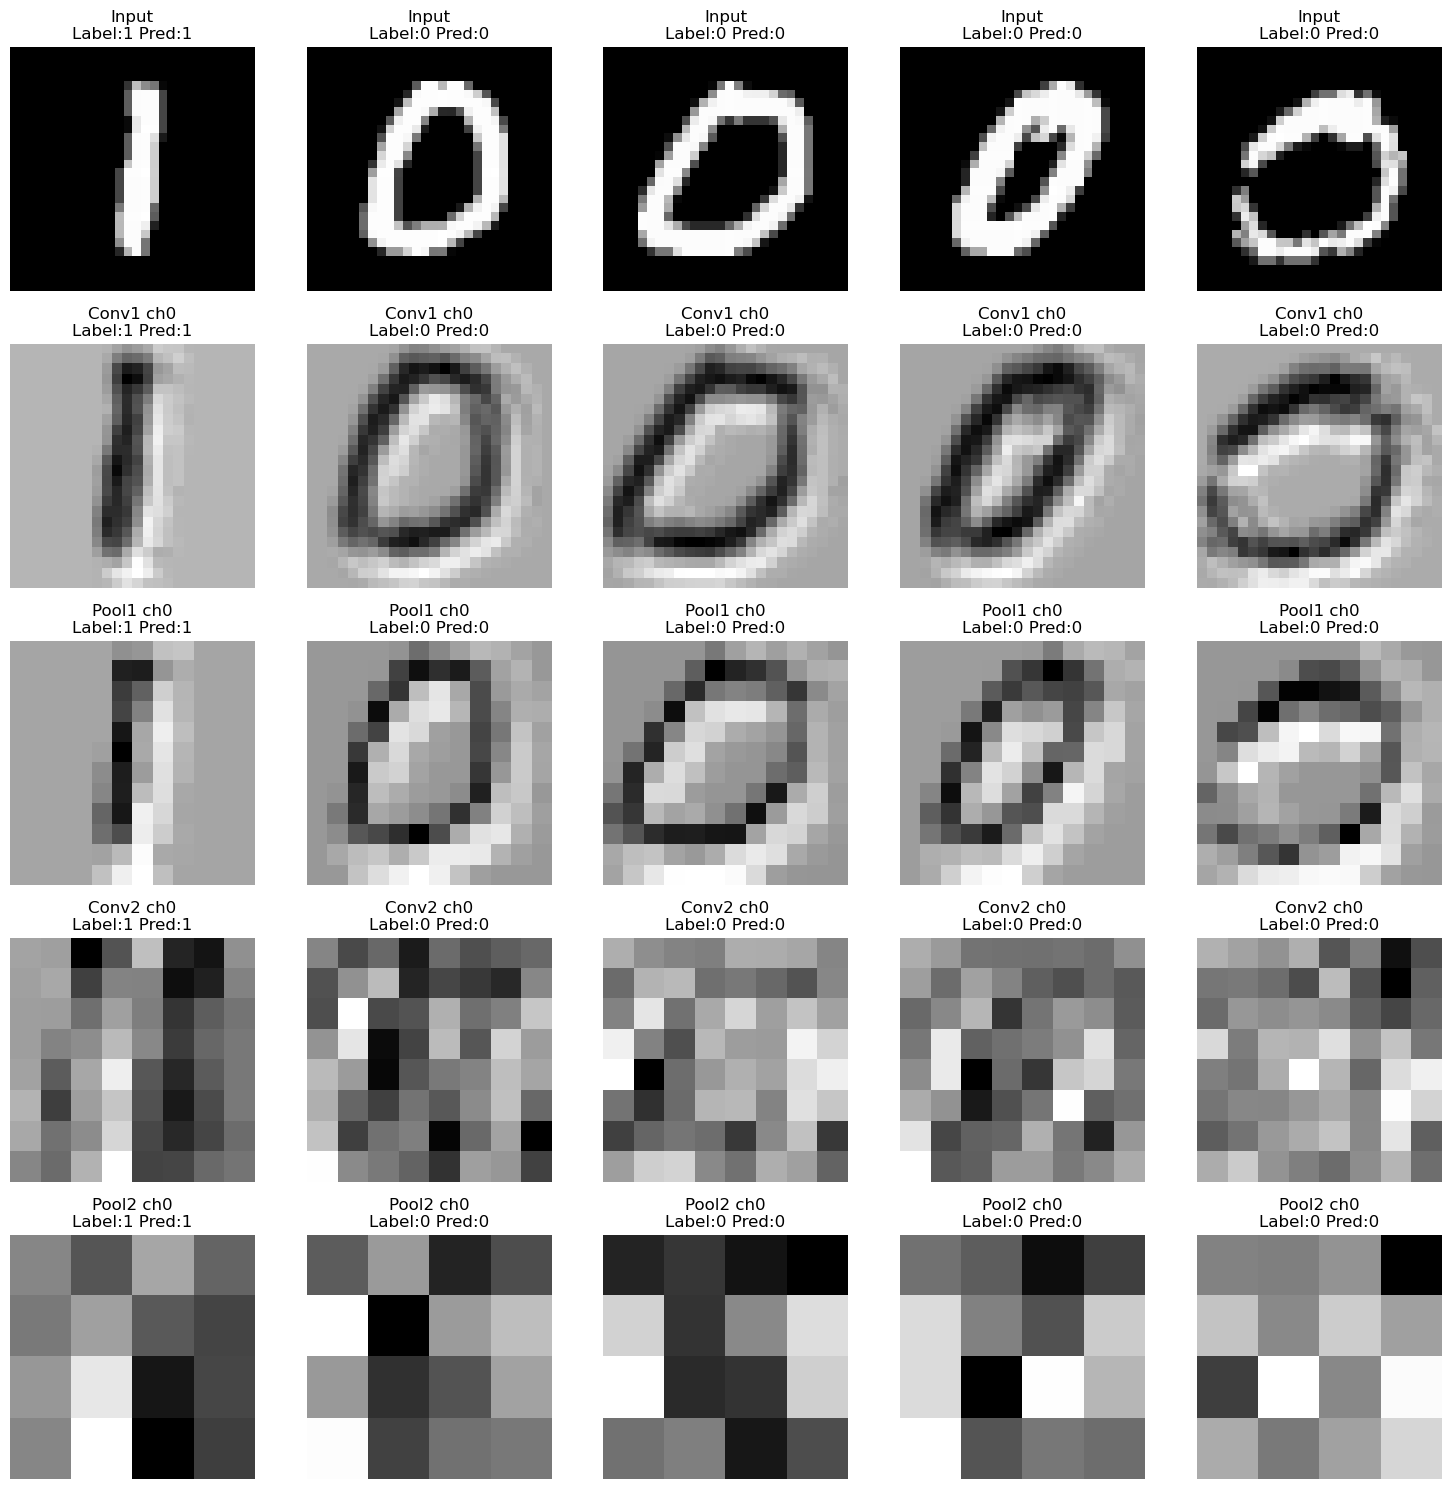

Shapes across pipeline:
{'Input': (5, 28, 28, 1), 'Conv1': (5, 24, 24, 6), 'Pool1': (5, 12, 12, 6), 'Conv2': (5, 8, 8, 16), 'Pool2': (5, 4, 4, 16), 'Flatten': (5, 256), 'FC1': (5, 120), 'FC2': (5, 84), 'Logits': (5, 2)}
Predictions (LeNet): [1 0 0 0 0]
Actual labels: [1 0 0 0 0]


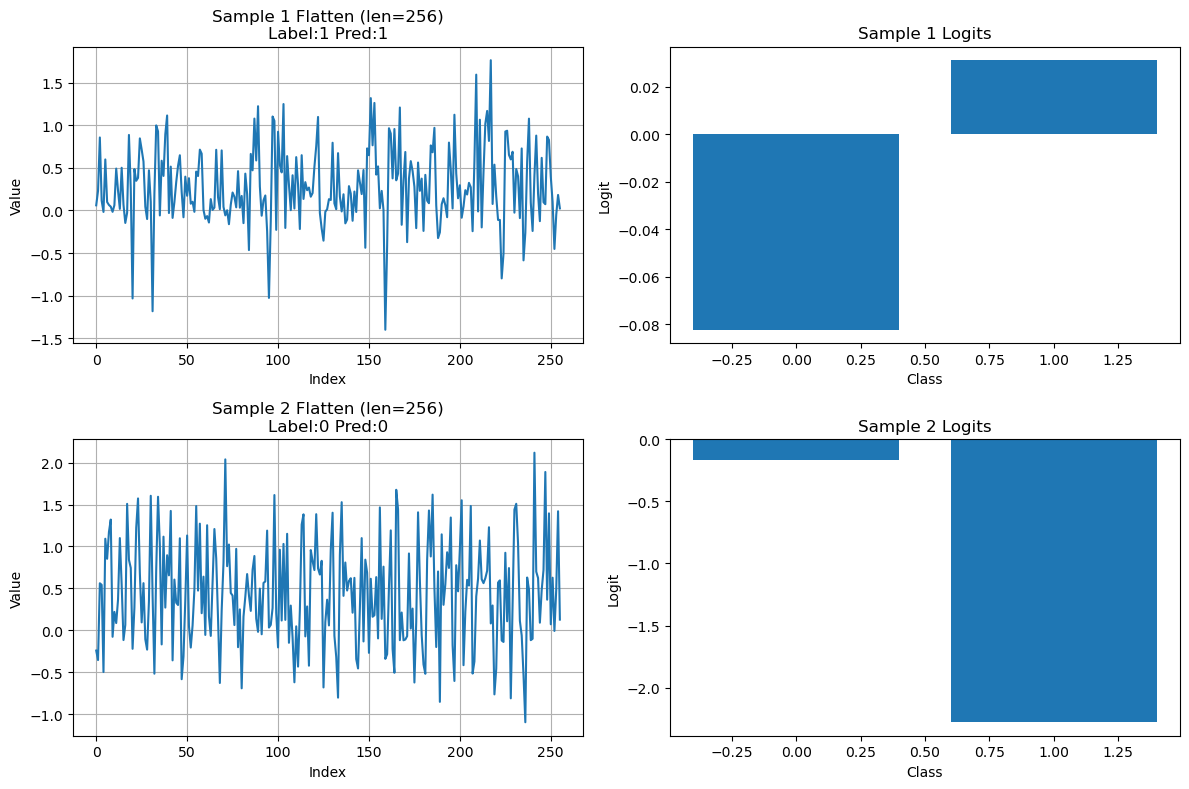

In [59]:
# Visualize LeNet feature maps for 5 samples across layers (including flatten and dense activations)
num_show = 5
images_batch, labels_batch = next(iter(test_loader))
k = min(num_show, images_batch.size(0))
imgs = images_batch[:k]
labels_np = labels_batch[:k].numpy()
X = imgs.permute(0, 2, 3, 1).numpy()  # NHWC

# Forward step-by-step to capture activations
conv1_out = model.conv1.forward(X)
pool1_out = model.pool1.forward(conv1_out)
conv2_out = model.conv2.forward(pool1_out)
pool2_out = model.pool2.forward(conv2_out)
flat_out = model.flatten.forward(pool2_out)
fc1_out = model.fc1.forward(flat_out)
fc2_out = model.fc2.forward(fc1_out)
logits = model.fc3.forward(fc2_out)
preds = np.argmax(logits, axis=1)

# Helper to plot one channel from each stage (spatial maps)
stages = [("Input", X[..., 0]), ("Conv1 ch0", conv1_out[..., 0]), ("Pool1 ch0", pool1_out[..., 0]), ("Conv2 ch0", conv2_out[..., 0]), ("Pool2 ch0", pool2_out[..., 0])]
fig, axes = plt.subplots(len(stages), k, figsize=(3 * k, 3 * len(stages)))
for r, (title, data) in enumerate(stages):
    for c in range(k):
        axes[r, c].imshow(data[c], cmap='gray')
        axes[r, c].set_title(f"{title}\nLabel:{labels_np[c]} Pred:{preds[c]}")
        axes[r, c].axis('off')
plt.tight_layout()
plt.show()

print("Shapes across pipeline:")
shape_info = {
    "Input": X.shape,
    "Conv1": conv1_out.shape,
    "Pool1": pool1_out.shape,
    "Conv2": conv2_out.shape,
    "Pool2": pool2_out.shape,
    "Flatten": flat_out.shape,
    "FC1": fc1_out.shape,
    "FC2": fc2_out.shape,
    "Logits": logits.shape,
}
print(shape_info)
print("Predictions (LeNet):", preds)
print("Actual labels:", labels_np)

# Plot flatten vectors and logits for first two samples
max_samples = min(2, flat_out.shape[0])
fig, axs = plt.subplots(max_samples, 2, figsize=(12, 4 * max_samples))
if max_samples == 1:
    axs = np.expand_dims(axs, axis=0)
for i in range(max_samples):
    axs[i, 0].plot(flat_out[i])
    axs[i, 0].set_title(f"Sample {i+1} Flatten (len={flat_out[i].shape[0]})\nLabel:{labels_np[i]} Pred:{preds[i]}")
    axs[i, 0].set_xlabel("Index")
    axs[i, 0].set_ylabel("Value")
    axs[i, 0].grid(True)
    axs[i, 1].bar(range(len(logits[i])), logits[i])
    axs[i, 1].set_title(f"Sample {i+1} Logits")
    axs[i, 1].set_xlabel("Class")
    axs[i, 1].set_ylabel("Logit")
plt.tight_layout()
plt.show()

### Interpreting the Flatten and Logits Plots (LeNet)
- **Flatten plot (256 values):** This is the 1D feature vector after all conv/pool layers. Peaks/valleys indicate which spatial patterns the network found salient. Different digits yield different “signatures” along these 256 positions.
- **Why we look at it:** It shows how spatial information is condensed before the dense layers. Clear, distinctive shapes here help the classifier separate classes.
- **Logits bar chart (2 columns):** Raw scores for class 0 and class 1. The higher logit wins after softmax. A large gap between the two bars means a confident prediction; a narrow gap means low confidence.
- **Why pred = 0 or pred = 1:** If the logit for class 0 > class 1, the model predicts 0; otherwise it predicts 1. The bar heights directly explain the decision.
- **Reading both together:** The flatten curve explains *what* features were extracted; the logits bars explain *how* those features tipped the final decision. A sharper, more discriminative flatten pattern usually correlates with a clearer logit gap and higher confidence.